#HW1 - Data Exploration and Preparation

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the dataset

In [22]:
dataset = pd.read_csv('virus_data.csv')

In [23]:
dataset.shape

(1250, 26)

In [24]:
def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

In [25]:
def plot3d(df, colX, colY, colZ, title, hue=None, s=1):
  %matplotlib inline

  fig = plt.figure(figsize=(20, 4))
  axes = [fig.add_subplot(1, 4, 1, projection='3d'),
          fig.add_subplot(1, 4, 2, projection='3d'),
          fig.add_subplot(1, 4, 3, projection='3d'),
          fig.add_subplot(1, 4, 4, projection='3d')]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if hue is None:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=s)
    else:
      idx = df[hue] == True
      df1 = df[idx]
      df2 = df[~idx]

      ax.scatter3D(df1[colX], df1[colY], df1[colZ], color=palette[0], s=s)
      ax.scatter3D(df2[colX], df2[colY], df2[colZ], color=palette[1], s=s)

    if i == 3 or i == 1:
      ax.set_xlabel(colX, labelpad=20)
      ax.set_ylabel(colY, labelpad=20)
    else:
      ax.xaxis.set_ticklabels([])
      ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i+15)

  axes[1].set_zlabel("\n" + colZ, labelpad=1)

  plt.suptitle(title)
  plt.subplots_adjust(wspace=0.1, top=0.99)
  plt.show()

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def prepare_data(training_data, new_data):

  # Copy the data
  train_df = training_data.copy()
  new_df = new_data.copy()

  # Add the SpecialProperty column & drop blood_type
  group_True = ['O+', 'B+']
  train_df['SpecialProperty'] = np.where(train_df['blood_type'].isin(group_True), 1, -1)
  new_df['SpecialProperty'] = np.where(new_df['blood_type'].isin(group_True), 1, -1)
  train_df = train_df.drop('blood_type', axis=1)
  new_df = new_df.drop('blood_type', axis=1)

  # Split the symptoms variable into columns
  train_df_new_cols = train_df['symptoms'].str.get_dummies(';')
  train_df_new_cols[train_df_new_cols == 0] = -1

  new_df_new_cols = new_df['symptoms'].str.get_dummies(';')
  new_df_new_cols[new_df_new_cols == 0] = -1

  train_df = pd.concat([train_df, train_df_new_cols], axis=1)
  new_df = pd.concat([new_df, new_df_new_cols], axis=1)

  train_df = train_df.drop('symptoms', axis=1)
  new_df = new_df.drop('symptoms', axis=1)

  # Split the gender column into "Male" and "Female"
  train_df['Female'] = np.where(train_df['sex'] == 'F', 1, -1)
  train_df['Male'] = np.where(train_df['sex'] == 'M', 1, -1)
  train_df = train_df.drop('sex', axis=1)

  new_df['Female'] = np.where(new_df['sex'] == 'F', 1, -1)
  new_df['Male'] = np.where(new_df['sex'] == 'M', 1, -1)
  new_df = new_df.drop('sex', axis=1)

  # Split location column into location_x and location_y
  train_df['location_x'] = [float(location.split("'")[1]) for location in train_df['current_location']]
  train_df['location_y'] = [float(location.split("'")[3]) for location in train_df['current_location']]
  train_df = train_df.drop('current_location', axis=1)

  new_df['location_x'] = [float(location.split("'")[1]) for location in new_df['current_location']]
  new_df['location_y'] = [float(location.split("'")[3]) for location in new_df['current_location']]
  new_df = new_df.drop('current_location', axis=1)

  train_df = train_df.drop('pcr_date', axis=1)
  train_df = train_df.drop('patient_id', axis=1)
  new_df = new_df.drop('pcr_date', axis=1)
  new_df = new_df.drop('patient_id', axis=1)


  # Columns designated for minmax scaling
  cols_for_minmax = ['PCR_01','PCR_02','PCR_03','PCR_06','cough','fever',
                    'shortness_of_breath','smell_loss','sore_throat','Female','Male', 'SpecialProperty']
  # Columns designated for standrad scaling
  cols_for_standard = ['age','weight','num_of_siblings','happiness_score','household_income',
                   'conversations_per_day','sugar_levels','sport_activity','location_x',
                   'location_y','PCR_04','PCR_05','PCR_07','PCR_08','PCR_09','PCR_10']

  # minmax scale all the minmax columns (in both training & test data, fit only training)
  scaler = MinMaxScaler(feature_range=(-1,1))
  scaler.fit(train_df[cols_for_minmax])
  new_df[cols_for_minmax] = scaler.transform(new_df[cols_for_minmax])

  # Standard scale all the standard columns
  scaler = StandardScaler()
  scaler.fit(train_df[cols_for_standard])
  new_df[cols_for_standard] = scaler.transform(new_df[cols_for_standard])

  return new_df

In [27]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(dataset, test_size=0.2, train_size=0.8, random_state=25)

# Prepare training set according to itself
train_df_preprocessed = prepare_data(data_train, data_train)

# Prepare test set according to the raw training set
test_df_preprocessed = prepare_data(data_train, data_test)

# Export the training DataFrame to a CSV file
train_df_preprocessed.to_csv('training_preprocessed.csv', index=False)

# Export the test DataFrame to a CSV file
test_df_preprocessed.to_csv('test_preprocessesd.csv', index=False)

Part 1: Basic model selection with k-Nearest Neighbors

Q1: Training a 1-NN model

C:\Users\yonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


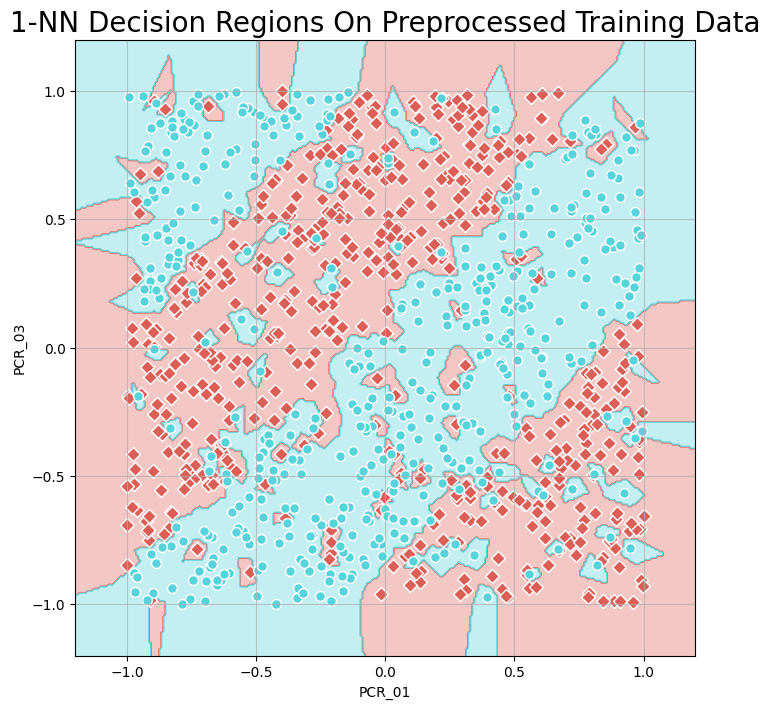

In [55]:
from sklearn.neighbors import KNeighborsClassifier

temp_df = train_df_preprocessed[['PCR_01', 'PCR_03']]

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(temp_df, train_df_preprocessed['spread'])
visualize_clf(knn, temp_df, train_df_preprocessed['spread'], "1-NN Decision Regions On Preprocessed Training Data",
               "PCR_01", "PCR_03")

Q2: Cross Validation

Best k value:  13
Its mean validation score:  0.8560000000000001
Its mean training score:  0.8641428571428571


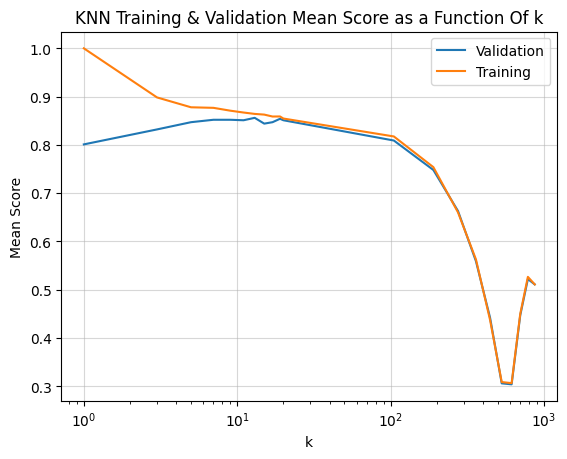

In [49]:
from sklearn.model_selection import cross_validate

# Save statistics in lists
validation_scores = []
training_scores = []
k_values = list(range(1, 20, 2)) + list(range(20, 871, 85))

# Iterate over different values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn, temp_df, train_df_preprocessed['spread'], cv=8, return_train_score=True)

    # Save mean scores
    validation_scores.append(cv_results['test_score'].mean())
    training_scores.append(cv_results['train_score'].mean())

# Plot the results
plt.semilogx(k_values, validation_scores, k_values, training_scores)
plt.xlabel('k')
plt.ylabel('Mean Score')
plt.title('KNN Training & Validation Mean Score as a Function Of k')
plt.legend(['Validation', 'Training'])
plt.grid(alpha=0.5)

print("Best k value: ", k_values[np.argmax(validation_scores)])
print("Its mean validation score: ", validation_scores[np.argmax(validation_scores)])
print("Its mean training score: ", training_scores[np.argmax(validation_scores)])

Q3: Training a K-NN With Optimal K Value

C:\Users\yonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


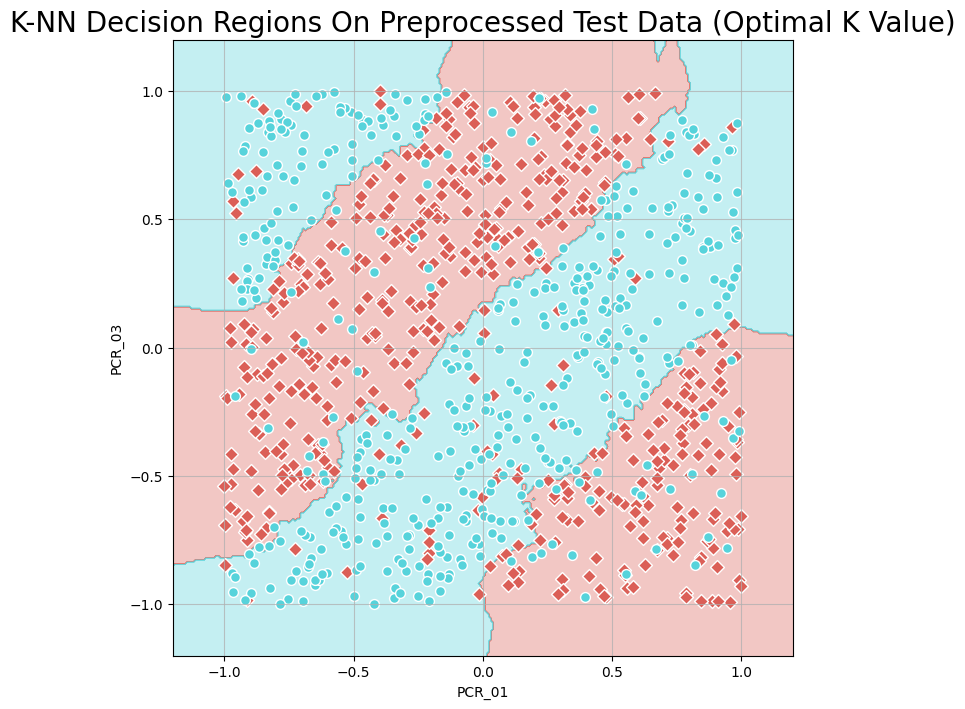

The test accuracy for the bets k value is: 0.868


In [54]:
# Create a KNN classifier with the best k value
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(temp_df, train_df_preprocessed['spread'])

# Visualize the decision regions
visualize_clf(knn, temp_df, train_df_preprocessed['spread'], "K-NN Decision Regions On Preprocessed Test Data (Optimal K Value)",
               "PCR_01", "PCR_03")

print("The test accuracy for the bets k value is:", knn.score(test_df_preprocessed[['PCR_01', 'PCR_03']], test_df_preprocessed['spread']))

Part 3: Decision Trees 

Q5: Training A Decision Tree With Max Depth Of 3

Training accuracy is:  0.713


[Text(0.5, 0.875, 'PCR_02 <= -0.43\nentropy = 0.999\nsamples = 1000\nvalue = [481, 519]\nclass = High'),
 Text(0.25, 0.625, 'SpecialProperty <= 0.0\nentropy = 0.894\nsamples = 209\nvalue = [65, 144]\nclass = High'),
 Text(0.125, 0.375, 'PCR_06 <= 0.025\nentropy = 0.999\nsamples = 103\nvalue = [53, 50]\nclass = Low'),
 Text(0.0625, 0.125, 'entropy = 0.619\nsamples = 52\nvalue = [44, 8]\nclass = Low'),
 Text(0.1875, 0.125, 'entropy = 0.672\nsamples = 51\nvalue = [9, 42]\nclass = High'),
 Text(0.375, 0.375, 'PCR_04 <= 0.491\nentropy = 0.51\nsamples = 106\nvalue = [12, 94]\nclass = High'),
 Text(0.3125, 0.125, 'entropy = 0.605\nsamples = 81\nvalue = [12, 69]\nclass = High'),
 Text(0.4375, 0.125, 'entropy = 0.0\nsamples = 25\nvalue = [0, 25]\nclass = High'),
 Text(0.75, 0.625, 'PCR_02 <= 0.535\nentropy = 0.998\nsamples = 791\nvalue = [416.0, 375.0]\nclass = Low'),
 Text(0.625, 0.375, 'PCR_06 <= -0.54\nentropy = 0.969\nsamples = 580\nvalue = [350, 230]\nclass = Low'),
 Text(0.5625, 0.125, 'e

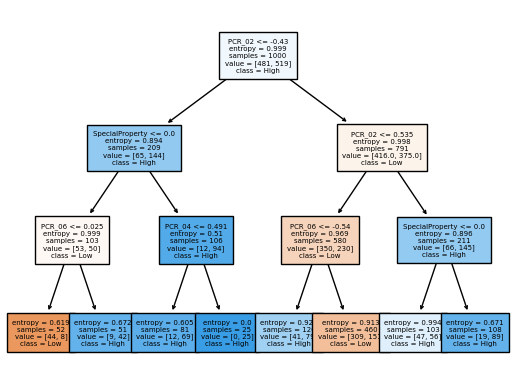

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Create a decision tree classifier
id3_dt = DecisionTreeClassifier(random_state=25, max_depth=3, criterion='entropy')

temp_df = train_df_preprocessed.drop('risk', axis=1)

# Fit the classifier to the training data
id3_dt.fit(temp_df, train_df_preprocessed['risk'])

print("Training accuracy is: ", id3_dt.score(temp_df, train_df_preprocessed['risk']))

# Visualize the decision tree
plot_tree(id3_dt, feature_names=temp_df.columns, class_names=['Low', 'High'], filled=True, fontsize=5)

Q6: Hyperparameter Tuning In ID3

In [109]:
from sklearn.model_selection import GridSearchCV

# Set parameters for grid search
parameters = {'max_depth': list(range(1, 6)), 'min_samples_leaf': list(range(1, 21))}

dt_id3 = DecisionTreeClassifier(criterion='entropy', random_state=25)
cv_results = GridSearchCV(dt_id3, parameters, cv=2, return_train_score=True)
cv_results.fit(temp_df, train_df_preprocessed['risk'])

print(cv_results.best_params_)
print("Validation accuracy is: ", cv_results.best_score_)

# Plot a heat map of the validation accuracy as a function of the best hyperparameters
cv_results_df = pd.DataFrame(cv_results.cv_results_)
cv_results_df.rename(columns={'param_max_depth': 'max_depth', 'param_min_samples_leaf': 'min_samples_leaf'}, inplace=True)
cv_results_df = cv_results_df.pivot(index='max_depth', columns='min_samples_leaf', values='mean_train_score')
sns.heatmap(cv_results_df, annot=False, cmap='viridis')

{'max_depth': 5, 'min_samples_leaf': 18}
Validation accuracy is:  0.681


KeyError: 'param_max_depth'